Version 05.10.2022, A. S. Lundervold.

# Introduction

This notebook builds on `DAT158-2.1-LinReg_GradientDescent.ipynb` and covers the following topics:

- **Polynomial regression:** Our data is often not neatly arranged along a straight line. We'll see how linear regression can be modified to handle data generated in more complex ways. We'll use this as motivation for the following three concepts below (which form the most crucial part of this discussion).


- **Learning curves:** This is a handy way to investigate whether your model is overfitting the training data.


- **Bias/variance tradeoff:** An essential concept in supervised machine learning, which will help you build better models.

See also Geron's notebook here: https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb

**This notebook will repeat some of what we covered in Part 1, in the notebook `DAT158-1.2-extra-Intro_to_ML.ipynb`.** It's helpful to study both of them.

# Setup

We set up our standard environment below.

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Polynomial regression

Let's make some data by using the quadratic function $2 + x + \frac12x^2$ with some added noise:

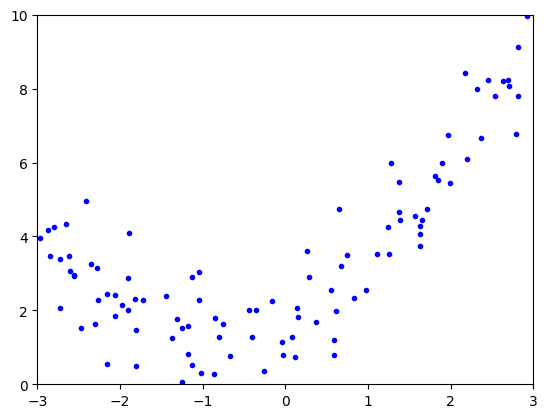

In [5]:
np.random.seed(seed)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m,1)

plt.plot(X,y, 'b.')
plt.axis([-3,3,0,10])
plt.show()

We can try to fit a straight line to these points using `scikit-learn` as in the previous notebook:

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

theta = [lin_reg.intercept_, lin_reg.coef_]

...use it to predict on a new value and plot the result:

In [ ]:
X_new = np.array([[-3], [3]]) # We choose two new x-values to create our predicted straight line
y_predict = lin_reg.predict(X_new)

plt.plot(X_new, y_predict, 'r')
plt.plot(X, y, 'b.')
plt.show()

..not very impressive. 

This is not surprising, as we're trying to fit a straight line to data generated from something more complicated.

Luckily, we can still use `LinearRegression`; we just have to add more features that turn our straight line into a polynomial. That is, we do linear regression in a higher dimension.

Instead of using the polynomial

$$y = \theta_0x_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$$

we use

$$y = \theta_0x_0 + \theta_1 x_1 + \theta_2 x_1^2 + \theta_3 x_1^3  + \cdots + \theta_k x_1^k + \theta_{k+1} x_2 + \theta_{k+2} x_2^2 + \cdots \theta_{nk} x_n^k$$

This is called **polynomial regression**.

## Polynomial regression by hand

Lets try it out by adding a new feature to `X` that is the square of the values in `X`:

In [ ]:
X_square = np.dstack((X, X**2))
X_square = X_square[:,0,:] # This tweak is needed to make LinearRegression happy below

Here are the first few values:

In [ ]:
X_square[:5]

Notice that the right column consists of the squares of the values in the left column.

We can use linear regression on these values:

In [ ]:
lin_reg_square = LinearRegression()
lin_reg_square.fit(X_square, y)

...and then predict values for a test set:

In [ ]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
# Add squares:
X_new_square = np.dstack((X_new, X_new**2))
X_new_square = X_new_square[:,0,:]

In [ ]:
y_new = lin_reg_square.predict(X_new_square)

In [ ]:
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.show()

**Great!**

Note that we have more parameters than for plain linear regression:

In [ ]:
lin_reg_square.intercept_, lin_reg_square.coef_

Our model produced the function 

{{"%.2f" % lin_reg_square.intercept_[0]}} + {{"%.2f" % lin_reg_square.coef_[0][0]}} x + {{"%.2f" % lin_reg_square.coef_[0][1]}} x^2

while the true function was 

$2 + x + \frac12 x^2$

## Using scikit-learn

This was the hard way to do it.. Of course, scikit-learn has built-in tools for creating polynomial features which lead to the exact same result:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [ ]:
X[:5]

In [ ]:
X_poly[:5] # Original feature of X and the square of it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

In [ ]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

In [ ]:
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.show()

## Higher order polynomial regression

We're not restricted to using only degree 2 polynomials. It's straightforward to add polynomial features of any degree!

Let's try degree 10:

In [ ]:
degree=10

But first, it's important to scale the data when using high-dimensional models (and when using gradient descent, as discussed earlier).

We want to perform these three steps:

<img src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/pipeline.png">

Once you're in a situation where you're taking more than a couple of steps to get from your data to predictions, you should use scikit-learn's `Pipeline` module, as you did in Assignment 1. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
#The following corresponds to the above diagram:
polynomial_regression = make_pipeline(
                                    PolynomialFeatures(degree=degree, include_bias=False),
                                    StandardScaler(),
                                    LinearRegression())

In [ ]:
# Fit using the entire pipeline:
polynomial_regression.fit(X, y)

# Predict on new data (using the pipeline):
y_new = polynomial_regression.predict(X_new)

# Plot the result
plt.axis([-3, 3, 0, 10])
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.show()

Let's make functions that investigates the effect of adding degrees:

In [ ]:
def get_pipeline(degree):
    poly_reg = make_pipeline(PolynomialFeatures(degree=degree, 
                                                include_bias=False),
                                                StandardScaler(),
                                                LinearRegression())
    
    return poly_reg

In [ ]:
def plot_poly_regression(degree, ax=None):
    
    polynomial_regression = get_pipeline(degree)
    polynomial_regression.fit(X, y)
    y_new = polynomial_regression.predict(X_new)
    if not ax: fig, ax = plt.subplots()
    ax.axis([-3, 3, 0, 10])
    ax.plot(X, y, "b.")
    ax.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
    ax.set_title(f'Degree {degree}')
    return ax

In [ ]:
_ = plot_poly_regression(1)

In [ ]:
_ = plot_poly_regression(2)

In [ ]:
_ = plot_poly_regression(5)

In [ ]:
_ = plot_poly_regression(20)

In [ ]:
_ = plot_poly_regression(300)

In [ ]:
degrees = [1, 2, 20, 300]
fig, axes = plt.subplots(2,2, figsize=(14,10))
for i,ax in enumerate(axes.flat):     
    plot_poly_regression(degrees[i], ax=ax)

Notice that as we increase the degree, we get a better and better fit to our data. However, as we get to higher and higher degrees, our model is less and less reasonable. It fits the training data well, but it tries too hard and ends up very different from what we know is the true data generating process (a polynomial of degree 2).

This is, as we know, what's called **overfitting**. Our model fails to **generalize** as it gets more and more complex.

> Even if a model fits well with the training data, it's not guaranteed to perform well on unseen test data, even if it gets 100% accuracy on the training data! This is the problem of **generalization**: what you're really interested in is models whose performance **generalize to new data**.

Earlier, we've used train-test-splits and cross-validation to help us detect when models were overfitting the training data. Now, let's look at another very useful tool for investigating model performance and doing model selection.

# Learning curves

The basic idea is to simultaneously measure the model's performance on the training data and on a validation data set as we increase the total data set size. It's the same concept as in human learning, where learning typically increases with experience:

<img width=60% src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/wikipedia_learning_curves.png"><br><small><center>Image from <a href="https://commons.wikimedia.org/wiki/File:Alanf777_Lcd_fig01.png">Wikipedia</a></center></small>

To achieve this we
1. Split the data into training and validation using `train_test_split`
2. Calculate the mean squared error for the model on the training and validation data as we increase the data size from 1 to all data points.
3. Plot the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Function taken from the textbook by A. Géron
def plot_learning_curves(model, X, y):
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # For storing the results
    train_errors, val_errors = [], []
    
    # Calculate RMSE as we increase the data size
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    # Plot the results
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14) 
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.title('Learning curves')

Let's try it out on our data using polynomial regression:

In [ ]:
def plot_learning_curves_linreg(degree, axis=[0, 80, 0, 3]):
    poly_reg = get_pipeline(degree)
    _ = plot_poly_regression(degree)
    plt.figure(figsize=(8,6))
    plot_learning_curves(poly_reg, X, y)
    plt.axis(axis)
    plt.show()  

In [ ]:
plot_learning_curves_linreg(degree=1)

In [ ]:
plot_learning_curves_linreg(degree=5)

In [ ]:
plot_learning_curves_linreg(degree=10)

**Two critical points to notice based on these plots:**

1. In the learning curve for standard linear regression (degree=1), we notice that the curves quickly stabilize to a relatively high error rate. Feeding the models more data doesn't help. This is what an **underfitting** model's learning curves typically look like: high training error and validation error close to training error. As we shall see, another way to say the same thing is that the model has a **high bias**.


2. When we use a high degree polynomial, for example, degree=10, we get a learning curve where there's a gap between the training and validation performance. The model scores very well on the training set but fails to obtain a similar score on the validation set. This is typical for models that are **overfitting** the training data and failing to generalize to new data: very low training error and much higher validation error. In other words, the model has **high variance**, as explained below.

> **Note:** Learning curves can be used to investigate the choice of K in a K-fold cross validation: a given choice of K can lead to different amounts of bias. One should try to avoid choosing K in such a way that the training sets in each fold become too small to provide good estimates of generalization performance (i.e., overestimates of the error). Using learning curves, one can get a sense of the number of training instances needed in each fold. 

> Note: scikit-learn has a built-in method for creating learning curves. Have a look at <a href="http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html">Plotting Learning Curves</a>.

# The bias/variance tradeoff

This is a crucial concept in supervised machine learning. Good knowledge of this concept helps you become a better machine learning engineer.

Bias and variance are two different sources of errors for machine learning models:


* The **bias** of a model comes from the simplifying assumptions made by the model to make the target function easier to approximate. In a high bias model, the assumptions don't fit well with the data (for example, assuming that the data is linear when it's really quadratic), typically resulting in underfitting.


* The **variance** of a model is an estimate of how much the model changes based on changes in the training data. In other words, how sensitive the model is to the precise data set. The high-degree polynomial above was very sensitive to the training data set because of its many degrees of freedom. A high variance model will tend to overfit. 

<img src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/biasvariance.png"><br><small><center>Image from http://scott.fortmann-roe.com/docs/BiasVariance.html</center></small>

There's a third source of errors for machine learning models: **irreducible error**. This comes from inherent uncertainty or noise in the data, which we can't fix unless we change the data.

## The tradeoff

Oversimplified models tend to have high bias, underfitting both the training and test data.  Increasing their complexity will lower their bias but increase their variance, making them poor at generalization.

> In general: the simpler the model, the higher the bias. The more complex the model, the higher the variance.

What you want is to find the sweet spot where the total error caused by the bias and the variance (and the irreducible error) is lowest:

<img src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/bias_variance_tradeoff.png"><br><small><center>Image from http://scott.fortmann-roe.com/docs/BiasVariance.html</center></small>

> In other words, you want to trade bias off with variance to minimize the generalization error (estimated using the test set). As we know, one cannot use the test set performance for model selection. Hence one has to use validation data to determine model complexity.

### 

**Mathematically:** Assume there is a relationship of the form $y = f(X) + \epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma_{\epsilon})$ represents the error due to noise. 

Using linear regression, or any other model, we estimate a model $\hat{f}(X)$ of $f(X)$. The expected squared predicted error at point x is $$\mbox{Err}(x) = E\big[\big(y - \hat{f}(x)\big)^2\big].$$

This can be decomposed into bias and variance components: $$\mbox{Err}(x) = \big(E[\hat{f}(x)] - f(x)\big)^2 + E\big[ \big(\hat{f}(x) - E[\hat{f}(x)]\big)^2 \big]+ \sigma_{\epsilon}^2$$

In other words:
$$\mbox{Err}(x) = Bias^2 + Variance + \mbox{Irreducible error}$$

### 

In our polynomial regression experiments above, the degree 2 and 3 seemed to give the best models. We can verify this by plotting the mean squared error for increasing degrees.

In [ ]:
poly_reg = get_pipeline(degree=1)

In [ ]:
from sklearn.model_selection import validation_curve

In [ ]:
degrees = range(1,17)

In [ ]:
train_scores, validation_scores = validation_curve(poly_reg, X, y,
                                                   param_name='polynomialfeatures__degree',
                                                   param_range=degrees,
                                                   scoring='neg_mean_squared_error', 
                                                   cv=5)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(degrees, -validation_scores.mean(axis=1), lw=2,
         label='validation')
plt.plot(degrees, -train_scores.mean(axis=1), lw=2, label='training')

plt.legend(loc='best')
plt.xlabel('degree')
plt.ylabel('MSE')
plt.show()

> How do we lower the variance of complex models? How do we force models to not overfit without losing generalization performance?

**Regularization** is the answer, and we'll cover it in the next notebook.

> **Your turn!**
- Find a good value for degree by using `GridSearchCV` on our `polynomial_regression` estimator.

> **Hint:** the degree inside the `polynomialfeatures` part of the `polynomial_regression` can be accessed via `polynomialfeatures__degree`. 